## Data

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import nltk
import pandas as pd
from nltk.corpus import stopwords
from config import BASE_DIR
import numpy as np
matplotlib.rcParams['figure.figsize'] = (15, 10)


**Conditions**
1. Books greater then 300 words.
2. Hebrew books.
3. Each book divided into 100 words chunks.

So we have 202 scrolls that match our criteria (with 39 compositions).
Only 129 scrolls have composition label.

In [7]:
CHUNK_SIZE=100
DATA_PATH = f"{BASE_DIR}/notebooks/data/filtered_text_and_starr_features_{CHUNK_SIZE}_words_nonbib_17_06_2024.csv"
df = pd.read_csv(DATA_PATH)
df_grouped = df.groupby("book")["text"].apply(' '.join).reset_index()
book_info = df[["book", "composition", "section"]].drop_duplicates()
df_by_book = pd.merge(df_grouped, book_info, on="book", how="inner")

df


,book,sentence_path,text_lex,text,n_words_lex,n_words,construct to absolute nouns ratio,construct nouns and adjectives percentage,noun to verb ratio,definite_article_percentage,...,aCr percentage,oM percentage,kya percentage,all conjunctions percentage,non-finite to finite verbs ratio,passive verb forms percentage,total word count,bib,section,composition
0,CD,CD:1:1-1:12,שמע כל ידע צדק בין מעשה אל ריב ל כל בשר משפט ע...,ועתה שמעו כל יודעי צדק ובינו במעשי אל כי ריב ל...,82,92,0.666667,0.110092,2.250000,0.917431,...,0.0,0.0,0.0,21.100917,0.333333,0.000000,109.0,nonbib,sectarian_texts,CD
1,CD,CD:1:12-2:1,אחרון עשה דור אחרון עדה בגד הם סור דרך היא עת ...,אחרונים את אשר עשה בדור אחרון בעדת בוגדים הם ס...,85,96,0.545455,0.114286,1.241379,4.761905,...,0.0,0.0,0.0,14.285714,0.705882,0.000000,105.0,nonbib,sectarian_texts,CD
2,CD,CD:2:1-2:10,כל המון מעשה נדה פנה שמע אל כל בוא ברית גלה אז...,את כל המונם ומעשיהם לנדה לפניו ועתה שמעו אלי כ...,79,94,0.481481,0.130841,2.222222,0.934579,...,0.0,0.0,0.0,17.757009,0.800000,1.869159,107.0,nonbib,sectarian_texts,CD
3,CD,CD:2:10-2:20,כל שנה עולם כל קום ל קריא שם יתר פליטה ארץ מלא...,לכל שני עולם ובכולם הקים לו קריאי שם למען התיר...,79,94,1.250000,0.205607,1.714286,0.934579,...,0.0,0.0,0.0,17.757009,0.615385,1.869159,107.0,nonbib,sectarian_texts,CD
4,CD,CD:2:20-3:8,בשר היה חרבה גוע היה היה עשה רצון שמר מצוה עשה...,בשר אשר היה בחרבה כי גוע ויהיו כלא היו בעשותם ...,81,95,1.100000,0.103774,1.000000,1.886792,...,0.0,0.0,0.0,18.867925,0.217391,6.603774,106.0,nonbib,sectarian_texts,CD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,11Q20,11Q20:14:8-14:17,נגע פנה שדה עצם אדם מות חלל חרב מות דם אדם מות...,יגע על פני השדה בעצם אדם מת ובחלל חרב או במת א...,78,92,0.478261,0.113208,1.545455,12.264151,...,0.0,0.0,0.0,23.584906,0.222222,0.943396,106.0,nonbib,unknown,Temple Scroll
1361,11Q20,11Q20:14:17-14:26,כל שרץ ארץ טמא חלד עכבר צב מין לטאה כח חמט תנש...,כול שרץ הארץ תטמאו החולד והעכבר והצב למינו והל...,73,91,0.416667,0.093458,1.700000,14.018692,...,0.0,0.0,0.0,23.364486,0.111111,1.869159,107.0,nonbib,unknown,Temple Scroll
1362,11Q20,11Q20:14:26-15:6,נשא עצם נבלה עור בשר צפרן כבס בגד רחץ מים בוא ...,הנושא מעצמותמה ומנבלתמה עור ובשר וצפורן וכבס ב...,80,95,0.375000,0.084906,1.333333,9.433962,...,0.0,0.0,0.0,22.641509,0.500000,0.000000,106.0,nonbib,unknown,Temple Scroll
1363,11Q20,11Q20:15:6-16:6,חיה בוא ירש ארץ אנכי נתן ל ירש כל יום איש לקח ...,תחיה ובאתה וירשתה את הארץ אשר אנוכי נותן לכמה ...,73,95,0.666667,0.076923,1.052632,7.692308,...,0.0,0.0,0.0,21.153846,0.187500,0.961538,104.0,nonbib,unknown,Temple Scroll


## Analysis

In [8]:
df_by_book["number_of_chars"] = df_by_book['text'].str.len()
df_by_book["number_of_words"] = df_by_book['text'].str.split().map(lambda x: len(x))
df_by_book["avg_word_length"] = df_by_book['text'].str.split().apply(lambda x: [len(i) for i in x]).map(
    lambda x: np.mean(x))


Books with the highest avg word length:

In [9]:
df_by_book.sort_values(by="avg_word_length", ascending=False)[["book", "avg_word_length"]].head(15)


,book,avg_word_length
47,4Q321a,4.864971
45,4Q320,4.852113
46,4Q321,4.847656
8,1QM,4.426585
62,4Q394,4.419028
78,4Q491,4.369184
65,4Q403,4.360927
63,4Q397,4.326291
75,4Q429,4.255000
76,4Q432,4.241667


In [10]:
df_by_book[df_by_book["book"] == "4Q321a"]["text"].to_list()

[' השנה הראשונה בארבעה בגמול באחד בראשון בחמשה בידעיה בשלושים בוא השנית ודוקו בששה במעוזיה בשבעה עשר בוא שבת בקוץ בשלושים בשני ודוקו באחד במלכיה בשבעה עשר בוא באחד באלישיב בתשעה ועשרים בשלישי ודוקו בשנים בישוע בששה עשר בוא בשלושה בבלגא בשמונה ועשרים ברביעי ודוקו בארבעה בחופה בחמשה עשר בוא בארבעה בפתחיה בשבעה ועשרים בחמישי ודוקו בחמשה בחזיר בארבעה עשר בוא בששה בדליה בשבעה ועשרים בששי ודוקו שבת בגמול בארבעה עשר בוא שבת בשעורים בחמשה ועשרים בשביעי ודוקו באחד בידעיה בשנים עשר בוא בשנים באביה בחמשה ועשרים בשמיני ודוקו בשלושה במימין  בשנים עשר בוא בשלושה ביקים בארבעה ועשרים בתשיעי ודוקו בארבעה בשכניה באחד עשר בוא בחמשה באמר בשלושה ועשרים בעשירי ודוקו בששה בישבאב בעשרה בוא בששה ביחזקאל בשנים ועשרים בעשתי עשר החודש ודוקו שבת בפתחיה בתשעה בוא באחד ביויריב בשנים ועשרים בשנים עשר החודש ודוקו בשנים בדליה בתשעה בוא השנית החודש הראשון בשנים במלכיה בעשרים בוא ודוקו בשלושה בחרים בשבעה בוא בארבעה בישוע בעשרים בשני ודוקו בחמשה בקוץ בשבעה בוא בחמשה בחופה בתשעה עשר בשלישי ודוקו בששה באלישיב בששה בוא שבת ב

Text(0.5, 1.0, 'Average word length')

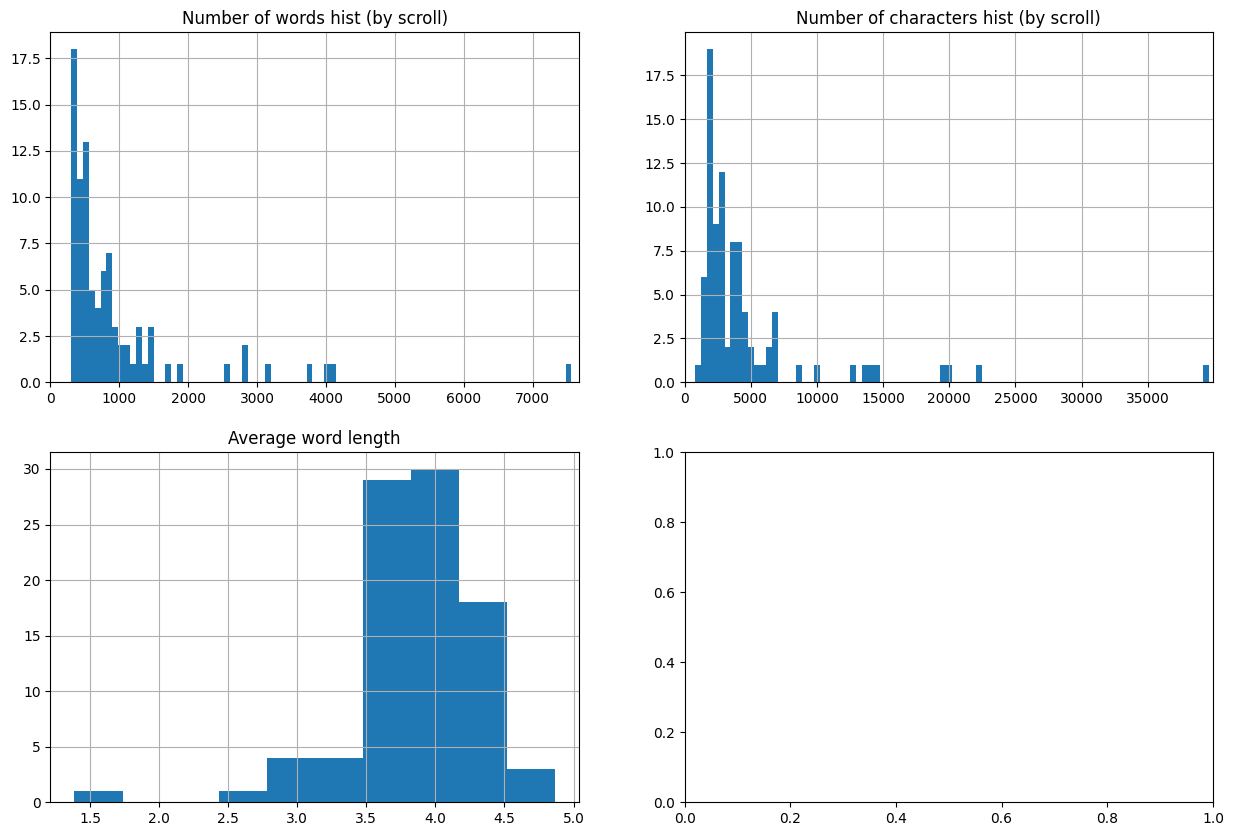

In [23]:
fig, ax = plt.subplots(2, 2)
df_by_book["number_of_words"].hist(ax=ax[0, 0], bins=100)
df_by_book["number_of_chars"].hist(ax=ax[0, 1], bins=100)
ax[0, 0].set_xlim(0, df_by_book["number_of_words"].quantile(0.99))
ax[0, 1].set_xlim(0, df_by_book["number_of_chars"].quantile(0.99))
df_by_book["avg_word_length"].hist(ax=ax[1, 0])
ax[0, 0].set_title("Number of words hist (by scroll)")
ax[0, 1].set_title("Number of characters hist (by scroll)")
ax[1, 0].set_title("Average word length")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yonatanlou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0.5, 1.0, 'Top 20 stop words in corpus')

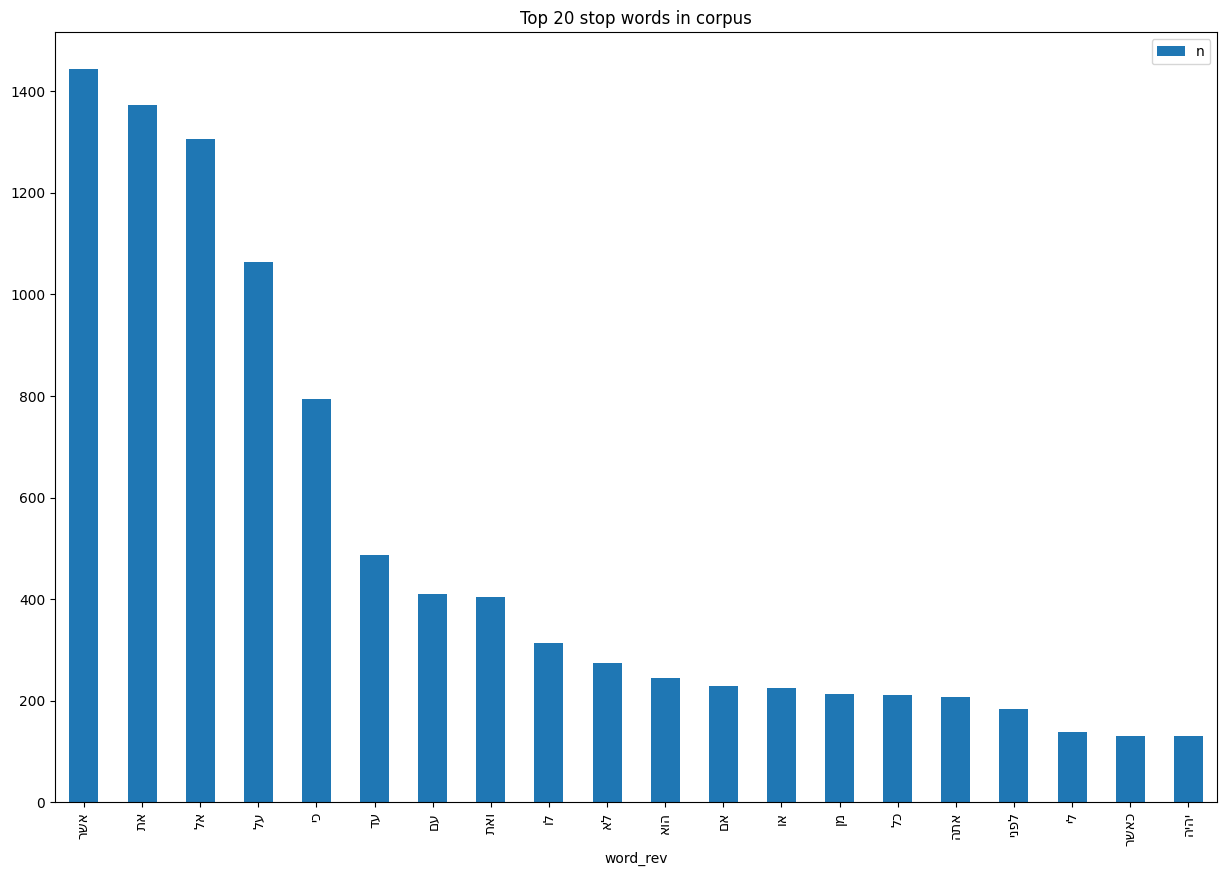

In [12]:
from collections import defaultdict

nltk.download('stopwords')
stop_words = set(stopwords.words('hebrew'))
corpus = []
words = df_by_book["text"].str.split()
words = words.values.tolist()
corpus = [word for i in words for word in i]

dic = defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word] += 1
stop_words_dist = pd.DataFrame([dic]).T.reset_index().rename(columns={0: "n", "index": "word"})
stop_words_dist["word_rev"] = stop_words_dist["word"].str[::-1]
stop_words_dist = stop_words_dist.set_index("word_rev")
stop_words_dist.sort_values(by="n", ascending=False).head(20).plot(kind="bar")
plt.title("Top 20 stop words in corpus")

<Axes: >

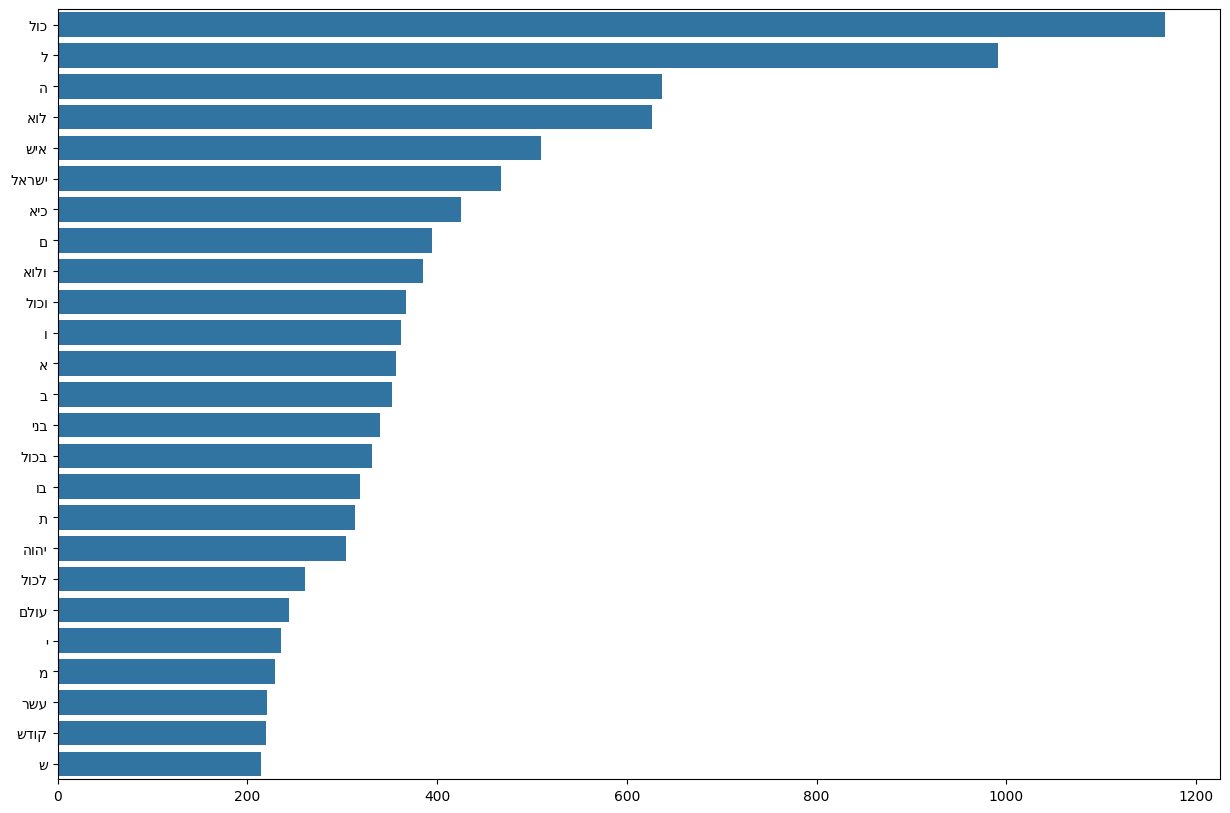

In [16]:
from collections import Counter

corpus = []
words = df_by_book["text"].str.split()
words = words.values.tolist()
corpus = [word for i in words for word in i]
corpus_no_punc = [word for word in corpus if word != "."]
corpus_no_letters = [word for word in corpus_no_punc if len(word)!=1]
counter = Counter(corpus_no_punc)
most = counter.most_common()

import seaborn as sns

x, y = [], []
for word, count in most[:40]:
    if (word not in stop_words):
        x.append(word[::-1])
        y.append(count)

sns.barplot(x=y, y=x)

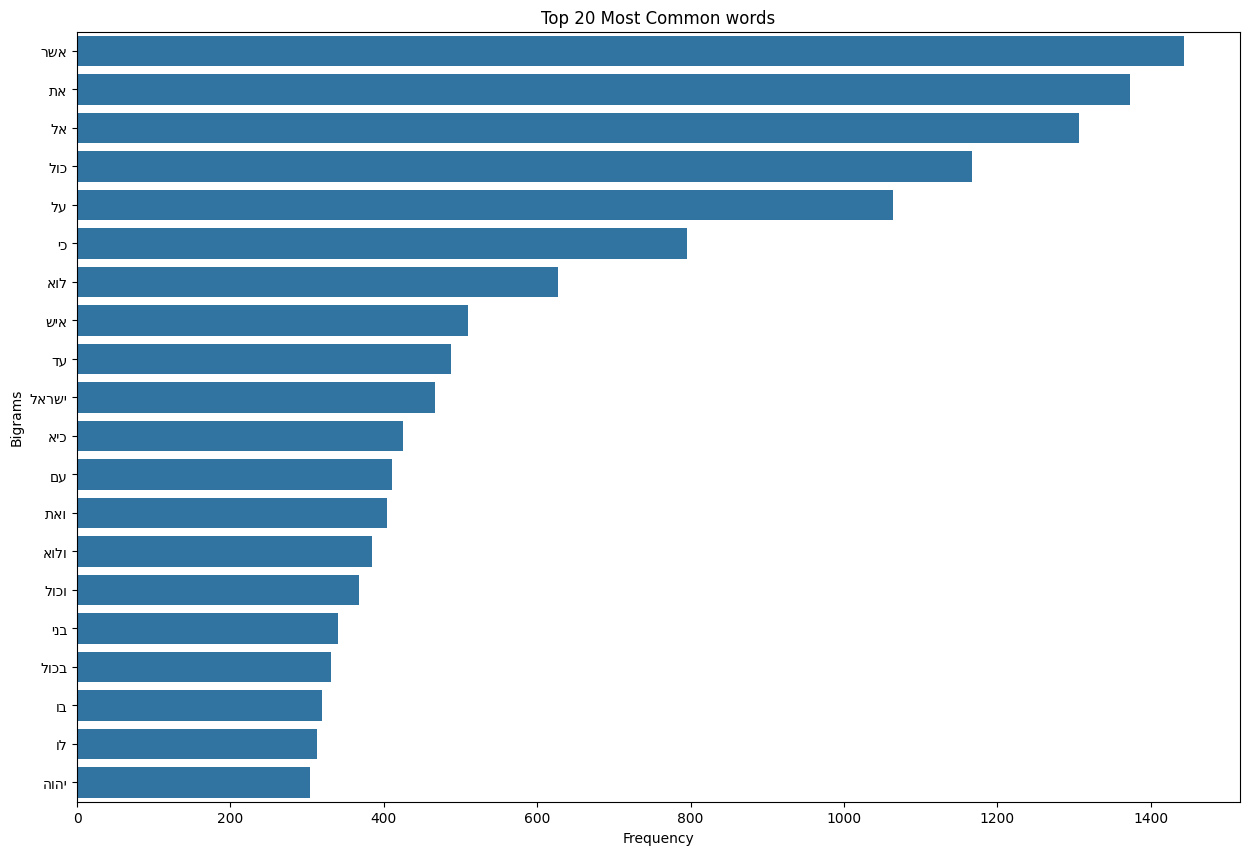

In [27]:
from nltk.util import ngrams
from collections import Counter


def most_common_ngram(words, n=2):
    # Tokenize the corpus into words

    # Generate n-grams
    n_grams = ngrams(words, n)

    # Count and find the most common n-gram
    ngram_freq = Counter(n_grams)
    most_common = ngram_freq.most_common()  # Returns the most common n-gram and its frequency
    return most_common


corpus_no_punc_rev = [word[::-1] for word in corpus_no_letters if word != "."]


def plot_ngram(words, k, n, title=""):
    top_n_bigrams = most_common_ngram(words, k)[:n]
    bigrams, counts = map(list, zip(*top_n_bigrams))
    bigrams = [' '.join(bigram) for bigram in bigrams]  # Convert tuple to string for better readability on plot

    sns.barplot(x=counts, y=bigrams)
    plt.xlabel('Frequency')
    plt.ylabel('Bigrams')
    plt.title(title)
    plt.show()


plot_ngram(corpus_no_punc_rev, 1, 20, 'Top 20 Most Common words')


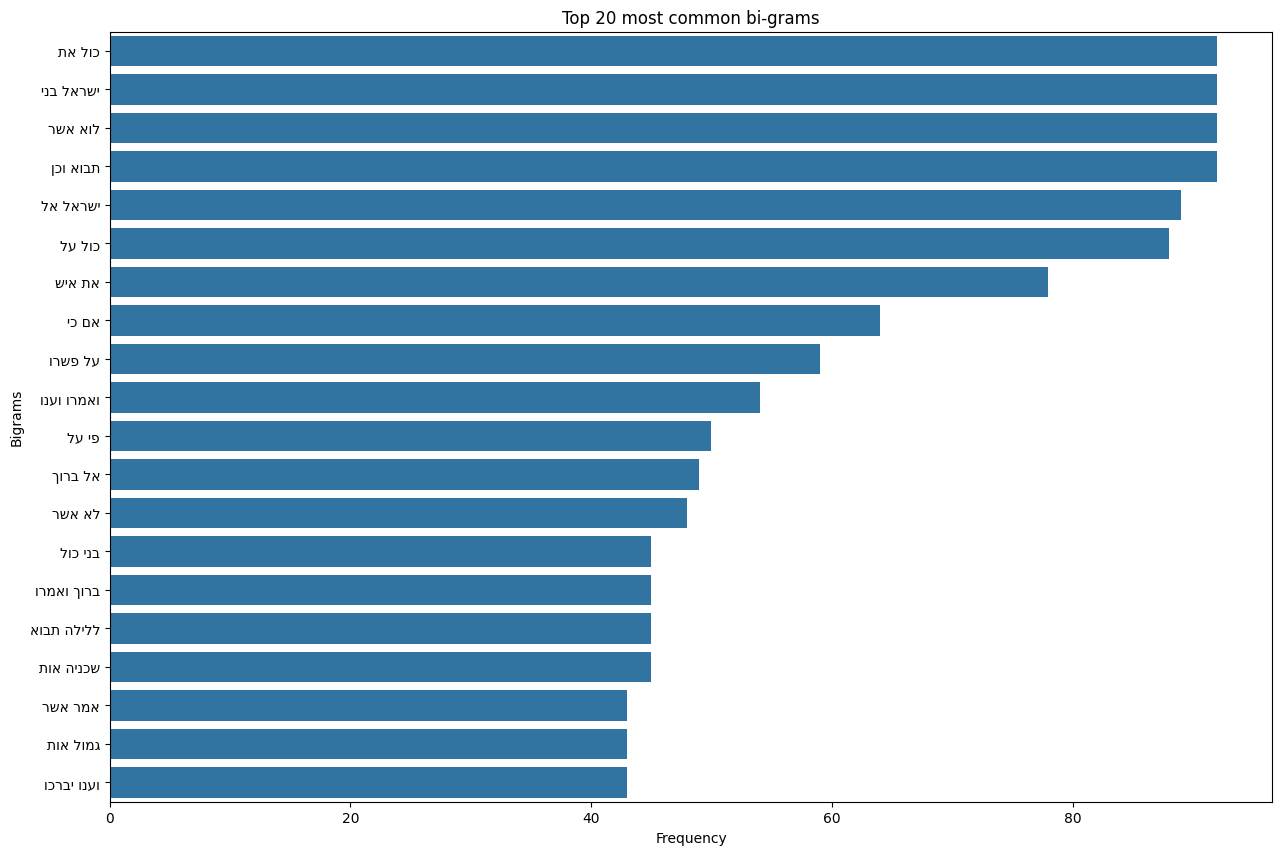

In [29]:
plot_ngram(corpus_no_punc_rev, 2, 20, "Top 20 most common bi-grams")